In [1]:
from IPython.display import Image
import datetime
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import time

from models import BaselineModel
from option_strats import BullCallSpread

# Ensure working directory path is correct
while os.path.split(os.getcwd())[-1] != "Options-Project":
    os.chdir(os.path.dirname(os.getcwd()))

# Set plotly theme
pio.templates.default = "ggplot2"

### User Defined Variables

12 sub-models, representing lags (days): `1`, `5`, `10`, `15`, `20`, `40`, `65` (1/4 year), `90`, `130` (1/2 year), `260` (1 year), `390`, `520`, `780` (3 years)

In [2]:
ticker = "AAPL"
adj_close_path = "data/adj_close/"
dividends_path = "data/dividends/"

sub_model_lags = [1, 5, 10, 15, 20, 40, 65, 90, 130, 260, 390, 520]
train_test_ratio = 0.9
kernel_resolution = 100

### Load Prediction Target

In [3]:
date_close_df = pd.read_csv(os.path.join(adj_close_path, ticker, (ticker + ".csv")))
date_close_df["date"] = pd.to_datetime(date_close_df["date"]).dt.date

dividends_df = pd.read_csv(os.path.join(dividends_path, ticker, (ticker + "_ts.csv")))
dividends_df["date"] = pd.to_datetime(dividends_df["date"]).dt.date
dividends_df["dividend"] = dividends_df["dividend"]

date_close_df = date_close_df[["date", "close"]].merge(right=dividends_df,
                                                       how="inner", on="date")

### Preprocess

In [4]:
date_close_df["adj_close"] = date_close_df["close"] - date_close_df["dividend"]

### Split Data

In [5]:
my_model = BaselineModel(sub_model_lags=sub_model_lags,
                         train_test_ratio=train_test_ratio,
                         kernel_resolution=kernel_resolution)

### Train Sub-Models

In [6]:
my_model.train_test_split(input_df=date_close_df)

my_model.train_models()

### Generate Sub-Model Kernels from Train


Kernels allow us to evaluate the performance of option strategies through probability densities.

Scipy's Gaussian KDE uses Scott’s Rule for bandwidth selection. Good enough for now. Our distribution seems uni-modal.

In [7]:
my_model.generate_kdes()

### KDE Heatmaps of All Sub-Models

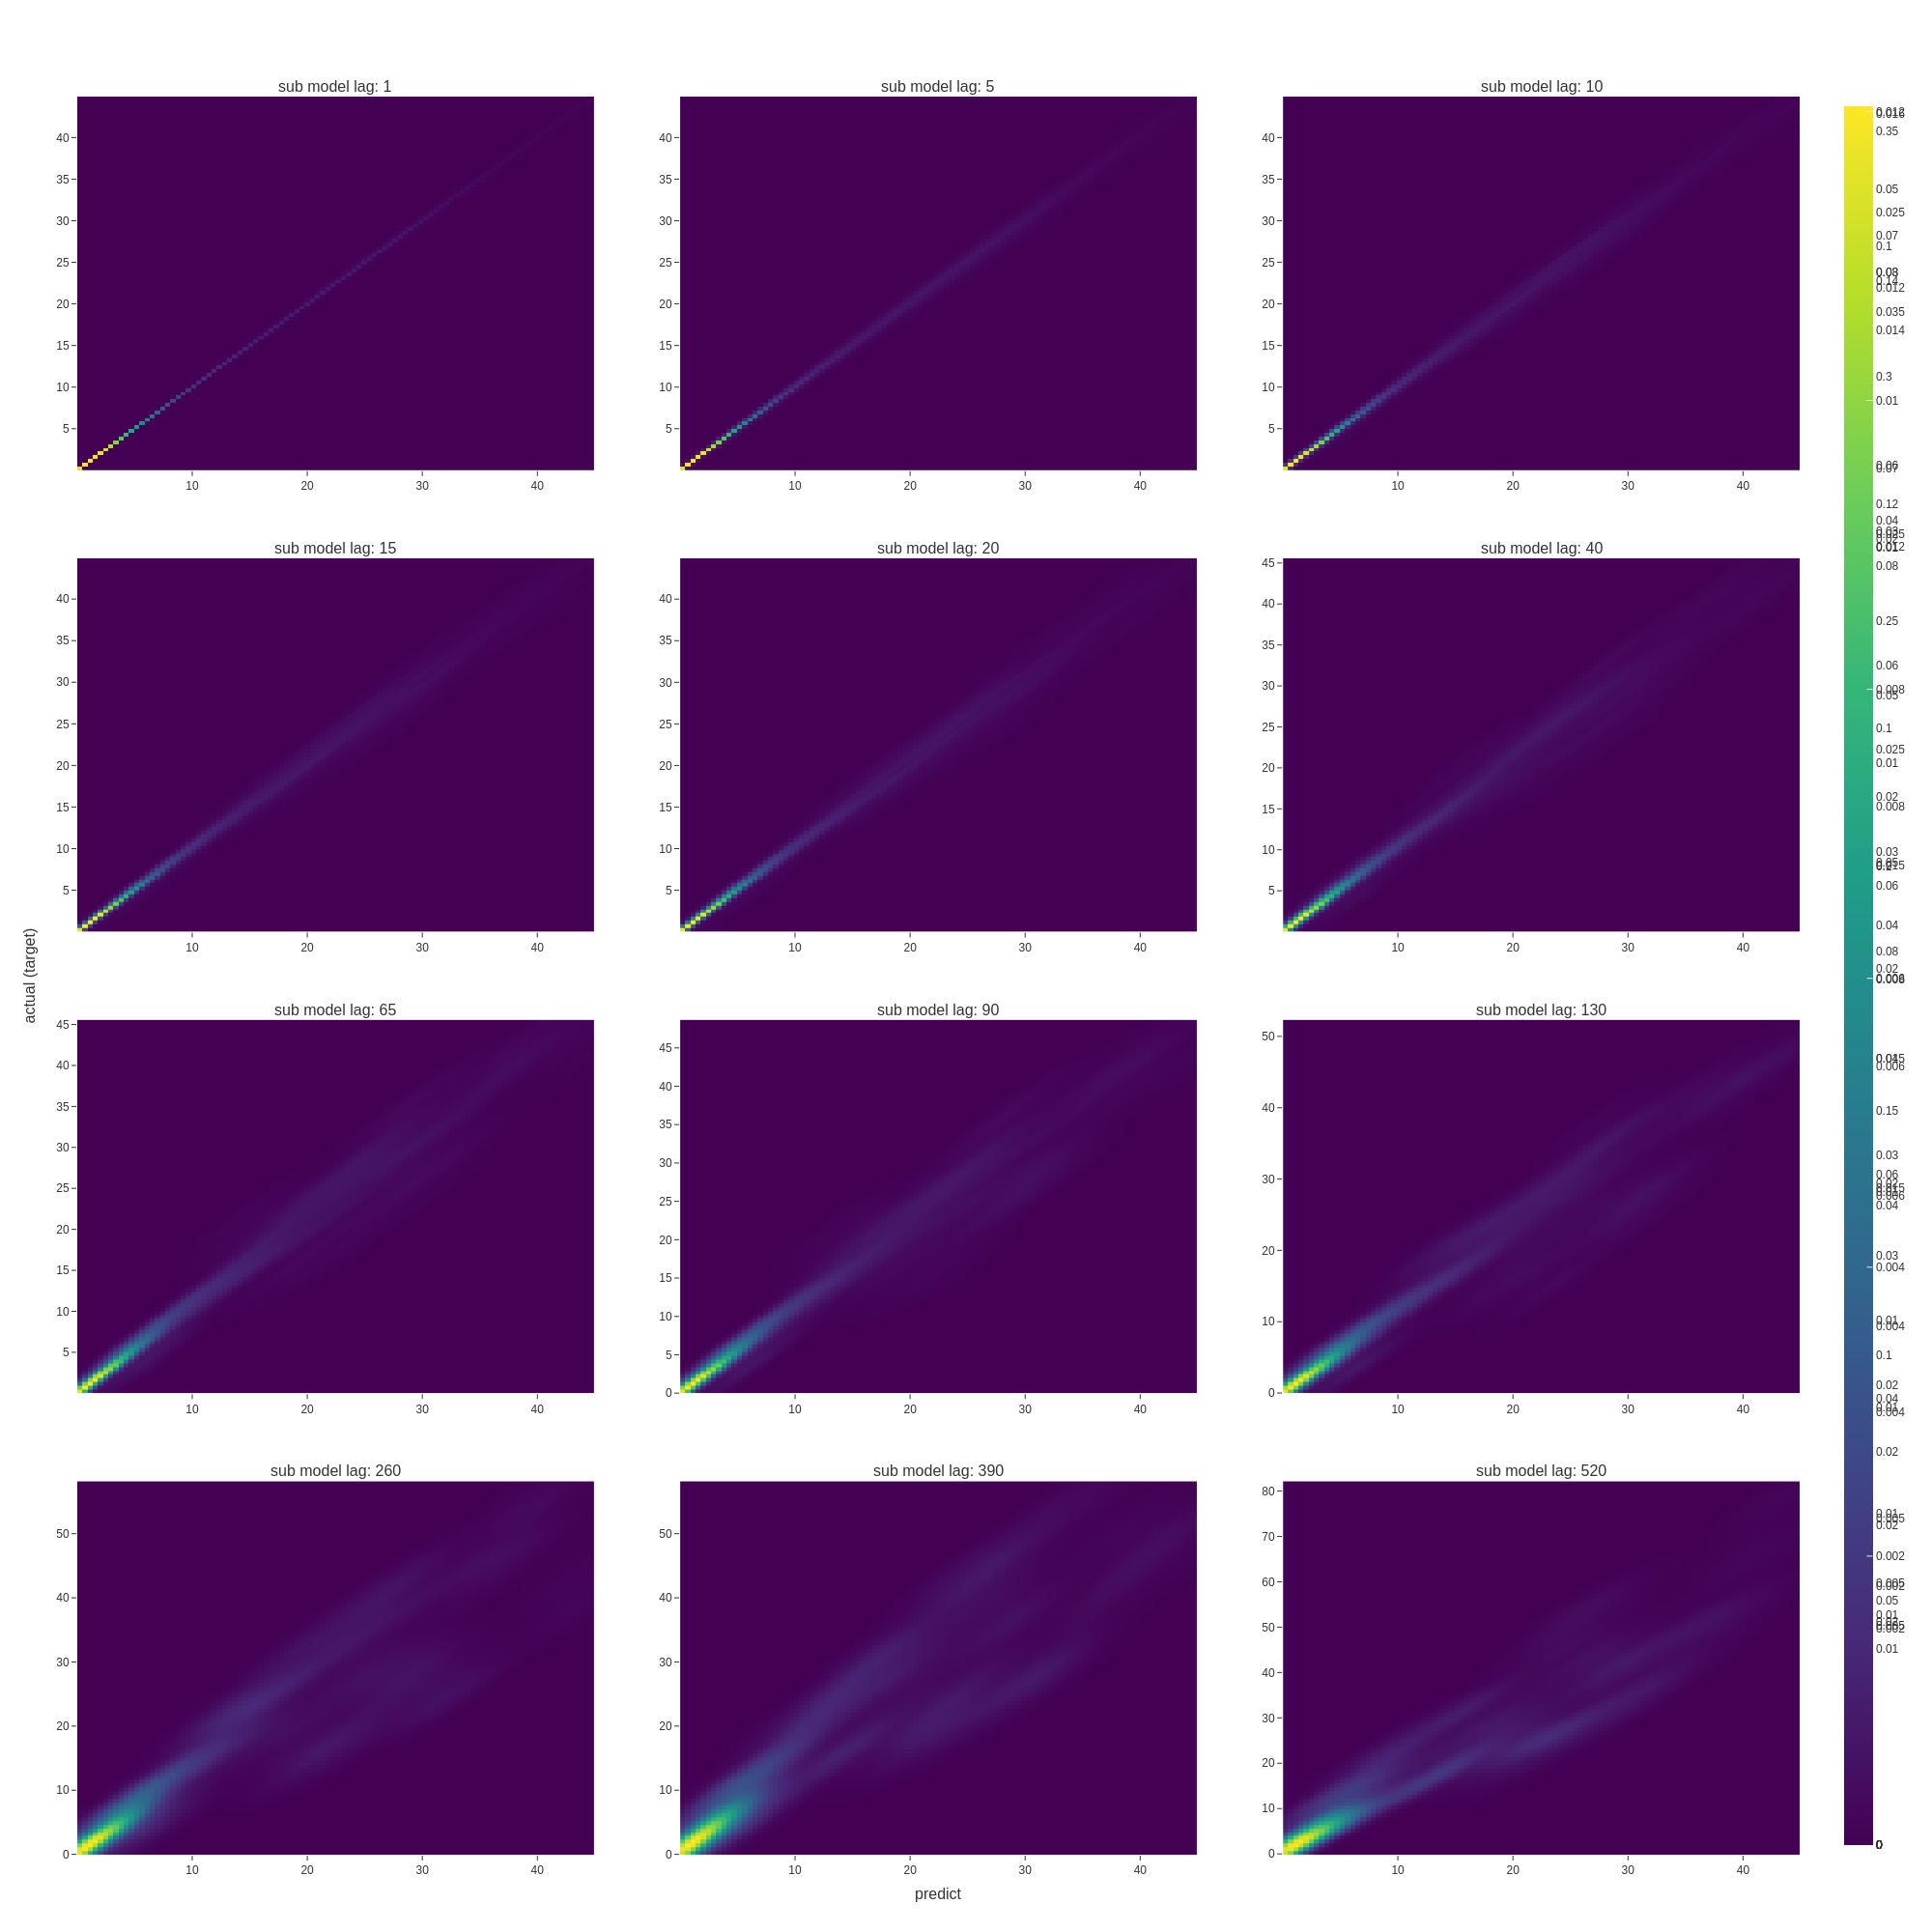

In [8]:
fig = my_model.plot_kde_heatmaps()

fig.write_image("./img/baseline_train_pdf_heatmap.png", width=2000, height=2000)
Image(filename="./img/baseline_train_pdf_heatmap.png")

### Generate Discrete Predictions for Test

In [9]:
my_model.predict_test()

### Generate PDFs from Kernels for Test Date Options

Using model **kernels from train** & **discrete predictions from test**, interpolate PDFs for all test **[date, expiration date]** combinations in options data


In [10]:
# Load Options Data
adj_options_path = f"data/adj_options/{ticker}"
year_df_list = []
test_dates = list(my_model.pred_test["date"])
test_years = list(np.unique([date.year for date in test_dates]))

In [11]:
start_time = time.time()

for year in test_years:
    for file in os.listdir(os.path.join(adj_options_path, str(year))):
        if file.split("_")[-1] in ["complete.csv"]:
            # Load
            file_df = pd.read_csv(os.path.join(adj_options_path, str(year), file))

            # Convert columns to correct format
            file_df["date"] = pd.to_datetime(file_df["date"]).dt.date
            file_df["expiration date"] = pd.to_datetime(file_df["expiration date"]).dt.date

            year_df_list.append(file_df)

test_options_df = pd.concat(year_df_list, ignore_index=True)

test_options_df = test_options_df[test_options_df["date"].isin(test_dates)]

test_options_df.sort_values(by=["date", "expiration date", "strike price", "tag"], inplace=True, ignore_index=True)

print(f"Read adj options - {round(time.time() - start_time, 2)} seconds")


Read adj options - 1.71 seconds


In [12]:
start_time = time.time()

my_model.generate_test_pdf(options_df=test_options_df)

print(f"Interpolate PDFs for all [data date, expiration date] - {round(time.time() - start_time, 2)} seconds")

Interpolate PDFs for all [data date, expiration date] - 128.46 seconds


### Postprocess

Revert preprocessing logic on discrete prediction and PDF

In [13]:
temp_df = my_model.pred_test_pdf.merge(dividends_df, left_on="expiration date", right_on="date",
                                       suffixes=("", "_y"),
                                       how="left", validate="m:1")

temp_df["prediction"] = (temp_df["prediction"] + temp_df["dividend"]).round(6)

temp_df["range"] = temp_df["range"] + temp_df["dividend"]

my_model.pred_test_pdf = temp_df.drop(columns=["date_y", "dividend"])

In [14]:
my_model.pred_test_pdf.head()

,date,expiration date,days to exp,prediction,pdf,range,bin width
0,2018-01-31,2018-02-02,2,41.862664,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.381462131147541, 0.8305726312303361, 1.2796...",0.449111
1,2018-01-31,2018-02-09,7,41.718389,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.23718682539682528, 0.6862973254796204, 1.13...",0.449111
2,2018-01-31,2018-02-16,12,41.732873,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2516709523809523, 0.7007814524637473, 1.149...",0.449111
3,2018-01-31,2018-02-23,17,41.744460,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2632582539682539, 0.7125142632675965, 1.161...",0.449256
4,2018-01-31,2018-03-02,22,41.758944,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2777423809523809, 0.7269983902517235, 1.176...",0.449256


### Bull Call Spread

#### Sample fig

In [15]:
fig_data_date = datetime.date(2018, 1, 31)
fig_exp_date = datetime.date(2020, 1, 17)

fig_options_df = test_options_df[(test_options_df["date"] == fig_data_date) &
                                 (test_options_df["expiration date"] == fig_exp_date) &
                                 (test_options_df["tag"] == "call")].reset_index(drop=True)

fig_pred_df = my_model.pred_test_pdf[(my_model.pred_test_pdf["date"] == fig_data_date) &
                                     (my_model.pred_test_pdf["expiration date"] == fig_exp_date)].reset_index(drop=True)

In [16]:
# For purpose of diagram, use calls with lowest and highest strikes
strike_1 = fig_options_df.loc[0, "strike price"]
ask_1 = fig_options_df.loc[0, "ask price"]

strike_2 = fig_options_df.loc[max(fig_options_df.index), "strike price"]
bid_2 = fig_options_df.loc[max(fig_options_df.index), "bid price"]

# Range of x-axis is based on prediction range
x_min = min(fig_pred_df.loc[0, "range"]) - fig_pred_df.loc[0, "bin width"]
x_max = max(fig_pred_df.loc[0, "range"]) + fig_pred_df.loc[0, "bin width"]

y_min = bid_2 - ask_1
y_max = y_min + strike_2 - strike_1

# Semantics on profit-loss curve of spread
call_spread_list = [[strike_1, y_min],
                    [strike_2, y_max]]

assert y_max > 0

if strike_1 > x_min:
    call_spread_list = [[x_min, y_min]] + call_spread_list

if x_max > strike_2:
    call_spread_list = call_spread_list + [[x_max, y_max]]

call_spread_df = pd.DataFrame(call_spread_list,
                              columns=["x", "y"])


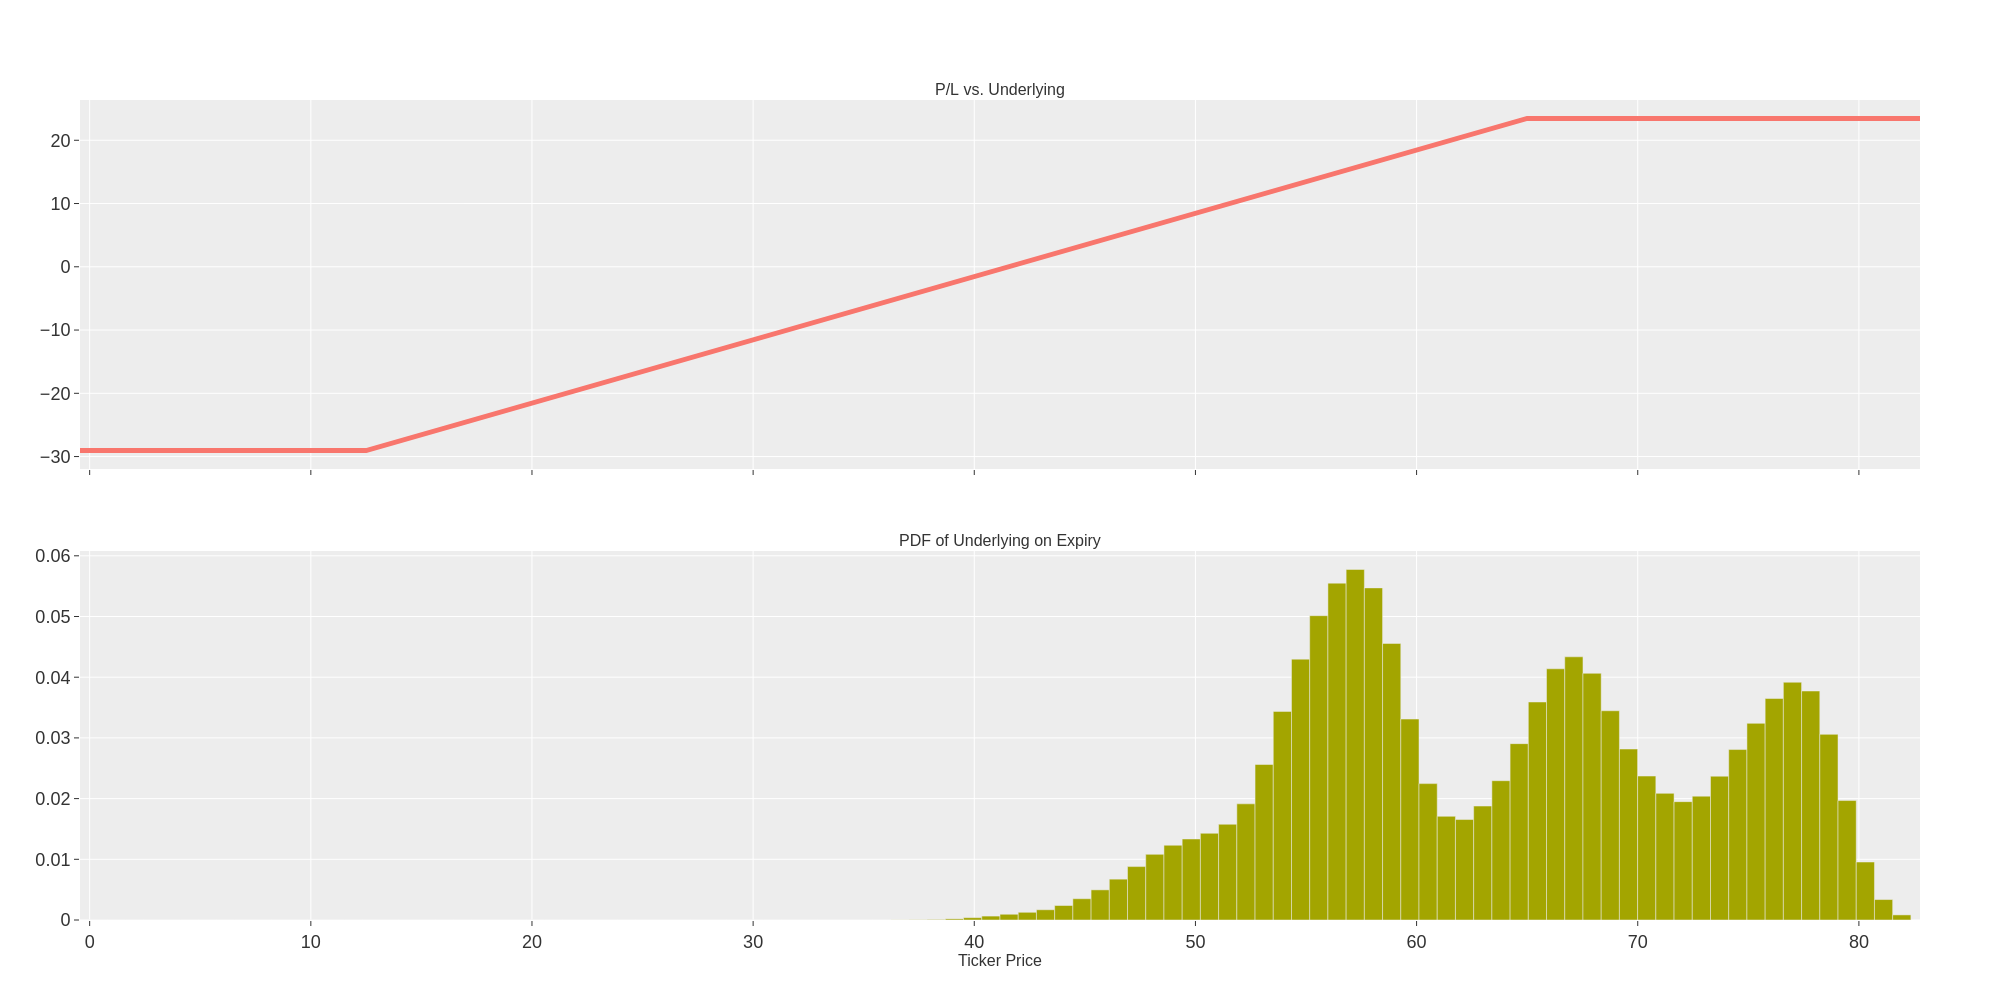

In [17]:
fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.1,
                    shared_xaxes=True,
                    x_title="Ticker Price",
                    subplot_titles=["P/L vs. Underlying", "PDF of Underlying on Expiry"])

fig.add_trace(go.Scatter(x=call_spread_df["x"], y=call_spread_df["y"],
                         mode='lines', line={"width": 5}),
              row=1, col=1)

fig.add_trace(go.Bar(x=fig_pred_df.loc[0, "range"],
                     y=fig_pred_df.loc[0, "pdf"],
                     width=fig_pred_df.loc[0, "bin width"]),
              row=2, col=1)

fig.update_layout(showlegend=False,
                  font={"size": 18})

fig.write_image("./img/baseline_sample_bull_call_spread.png", width=2000, height=1000)
Image(filename="./img/baseline_sample_bull_call_spread.png")


#### Optimize for best option pairs

For each pair of [data date, expiration date], scan through all possible pairs of options to create a bull call spread. Calculate the most "profitable" pair by integrating the PDF (bottom plot) weighted by the profit / loss at such ticker price (top plot)

We take the 10 (arbitrarily chosen) most profitable pair given that the integral > 0 (overall profitable). Otherwise, skip that [data date, expiration date]

We also assume that ask / bid size are infinite for all options. Implement ask / bid size in future

In [18]:
start_time = time.time()

calc_options = BullCallSpread(dates=test_dates)

scores_df = calc_options.run(options_df=test_options_df,
                             pred_pdf_df=my_model.pred_test_pdf)

print(f"Calculate bull call spread scores - {round(time.time() - start_time, 2)} seconds")

Calculate bull call spread scores - 37.55 seconds


In [19]:
scores_df.head()

,date,expiration date,strike 1,strike 2,investment cost,score
0,2018-01-31,2018-02-02,36.5,41.875,4.425,0.698114
1,2018-01-31,2018-02-02,33.75,41.875,7.1875,0.685614
2,2018-01-31,2018-02-02,37.5,41.875,3.45,0.673114
3,2018-01-31,2018-02-02,36.25,41.875,4.7,0.673114
4,2018-01-31,2018-02-02,36.0,41.875,4.95,0.673114
